# Developing a Quality Assurance Classifier for Engineering Corps

In [1]:
#Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import sklearn as sk
from sklearn.feature_selection import f_classif, chi2
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from xgboost import XGBClassifier
from sklearn.utils import resample
from scipy import stats

# 1. Load data into Pandas to understand what we are dealing with.

In [2]:
labels = pd.read_csv('labels.data', names=['labels', 'Date and Time'], sep=' ', infer_datetime_format=True)
measurements = pd.read_csv('measurements.data', header=None, sep=' ')
labels.head()

,labels,Date and Time
0,-1,19/07/2008 11:55:00
1,-1,19/07/2008 12:32:00
2,1,19/07/2008 13:17:00
3,-1,19/07/2008 14:43:00
4,-1,19/07/2008 15:22:00


### Above we have labels for failure as well as date and time for each reading. Successfully loaded in.

In [3]:
measurements.head()

,0,1,2,3,4,5,6,7,8,9,...,580,581,582,583,584,585,586,587,588,589
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,NaN,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,0.0060,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,...,0.0148,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602
3,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,...,0.0044,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,...,NaN,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432


## Note:
1. There is 590 columns of sensor data here which does not correspond to the 591 different sensors stated in the brief sheet. Upon visual inspection of the data file I cannot see discrepancies in the way pandas has loaded it. The final sensor may be the time in the labels file.
2. The data is currently expressed in many different scales and so feature scaling will be required, prior to any machine learning.
3. There are missing NaN values in the sensor data that must be accounted for.

In [4]:
print('The size of the measurements dataframe is ' + str(measurements.values.shape))
float_check = measurements.dtypes == np.float64
print('The size of float_check is ' + str(float_check.shape) + " and the sum of columns that are floats are " + str(float_check.sum()))
print('Meaning all sensor data in the measurements file is numeric and there are 1567 samples per sensor.')

The size of the measurements dataframe is (1567, 590)
The size of float_check is (590,) and the sum of columns that are floats are 590
Meaning all sensor data in the measurements file is numeric and there are 1567 samples per sensor.


In [5]:
print('The size of the labels dataframe is ' + str(labels.values.shape))
print('The data types contained in the labels dataframe is \n' + str(labels.dtypes))
print('The number of sensor samples in labels, matches the samples in measurements which is a good sanity check. It also means each timestamp corresponds to the sensor measurements.')

The size of the labels dataframe is (1567, 2)
The data types contained in the labels dataframe is 
labels            int64
Date and Time    object
dtype: object
The number of sensor samples in labels, matches the samples in measurements which is a good sanity check. It also means each timestamp corresponds to the sensor measurements.


In [6]:
print('Missing values = ' + str(measurements.isnull().sum(axis = 0).sum()))
print('Total values = ' + str(measurements.values.size))
percentage_missing = 100*measurements.isnull().sum(axis = 0).sum()/measurements.values.size
print('Percentage values missing = ' + str(percentage_missing) + '%')

Missing values = 41951
Total values = 924530
Percentage values missing = 4.537548808583821%


## Note:
1. 4.5% of all the data is missing.
2. I will make an assumption to replace this missing data with the mean values in each column.
3. I will do this after mean normalisation so as to not affect the standard deviation.
4. I believe this will not affect the results too much because I will be mean-normalising the data anyway.

## Check how the NaN values are distributed

In [7]:
column_na_count = measurements.isna().sum(axis=0).values
print(column_na_count)
keep_columns = np.where(column_na_count < (1567/2))
sensor_data = measurements.values.copy()
sensor_data = sensor_data[:,keep_columns[0]]
print(keep_columns[0].shape)

[   6    7   14   14   14   14   14    9    2    2    2    2    2    3
    3    3    3    3    3   10    0    2    2    2    2    2    2    2
    2    2    2    2    1    1    1    1    1    1    1    1   24   24
    1    1    1    1    1    1    1    1    1    1    1    4    4    4
    4    4    4    7    6    6    6    7    7    7    6    6    6    6
    6    6  794  794    6   24   24   24   24   24   24   24   24    1
   12 1341    0    0    0   51   51    6    2    2    6    6    6    6
    6    6    6    6    6    2    2    6    6    6    6 1018 1018 1018
  715    0    0    0    0    0   24    0    0    9    9    9    9    9
    9    9    9    9    9    9    8    8    8    5    6    7   14   14
   14   14   14    9    2    2    2    2    2    3    3    3    3    3
    3   10    0 1429 1429    2    2    2    2    2    2    2    2    2
    2    2    1    1    1    1    1    1    1    1   24    1    1    1
    1    1    1    1    1    1    1    1    4    4    4    4    4    4
    7 

# Note:

1. Certain sensors have large clusters of NaN values which implies the data is not good or largely missing.
2. If sensors have more than half their samples as NaN values then remove that sensor from the analysis as you will end up with mainly noise when processing later.
3. This now leaves 562 sensors instead of the original 590.

In [8]:
def mean_normalisation(X):
    mu = np.nanmean(X, axis=0)
    sigma = np.nanstd(X, axis=0)
    X_norm = (X[:,]-mu)/sigma
    return mu, sigma, X_norm

In [9]:
def NaNsToZero(X):
    # Setting nan values to zero now that the data has been feature scaled. (Equivalent to setting to mean)
    nan_rows, nan_cols = np.where(np.isnan(X))
    inf_rows, inf_cols = np.where(np.isinf(X))
    X[nan_rows, nan_cols]=0
    X[inf_rows, inf_cols]=0
    return X

# 2. Extract and process labels

In [10]:
# Copy labels to a numpy array and set labels to 0 and 1.
sensor_labels = labels['labels'].values.copy()
sensor_labels[sensor_labels>0] = 1
sensor_labels[sensor_labels<0] = 0
print(sensor_labels)
success_rate = 100*sensor_labels.sum()/sensor_labels.size
print('%success = ' + str(success_rate))

[0 0 1 ... 0 0 0]
%success = 6.636885768985322


## Note:
1. Labelled data is very skewed, meaning very few success rates. This will be hard to train with a typical supervised learning classifier, also must take extra care when assessing precision and recall.
2. Could be worth removing successes and training an anomally detection algorithm instead with success as the anomaly.

# 3. Start with a Supervised Learning Problem
Lets split the data set into train, test, ensuring there is an even proportion of successes in each set using stratified sampling.

## 3.1 Implementing a Logistic Regression Classifier with regularisation.

In [34]:
# Shuffle the sensor data and labels, note you are ignoring effects of time.

#I have used Stratified sampling here to maintain the same proportion of success/failures through out the train and test sets as well as KFold cross validation to help increase the amount of training available.
skf= StratifiedKFold(n_splits=3, random_state=5, shuffle=True)
for train_index, test_index in skf.split(sensor_data, sensor_labels):
    X_train, X_test = sensor_data[train_index], sensor_data[test_index]
    y_train, y_test = sensor_labels[train_index], sensor_labels[test_index]
    
    # Carry out mean normalisation
    mu, sigma, X_train_norm = mean_normalisation(X_train)
    X_test_norm = (X_test[:,]-mu)/sigma
    
   
    # Convert nans to zero (essentially making them mean values)
    X_train_norm = NaNsToZero(X_train_norm)
    X_test_norm = NaNsToZero(X_test_norm)
    
    # Run logistic regression on data set with l1 regularisation to reduce feature space.
    clf = LogisticRegression(random_state=5, solver='saga', max_iter=1000, penalty='l1').fit(X_train_norm, y_train)
    y_pred=clf.predict(X_test_norm)
    y_prob = clf.predict_proba(X_test_norm)
    
    print(y_pred)
    
    # Note that pos_label=1 because although we are assessing how well the algorithm identifies failures, the highly unbalanced properties of this data set mean that even 
    #precision and recall have created a bias towards classifying failure.
    fpr, tpr, thresholds = sk.metrics.roc_curve(y_test, y_prob[:,1], pos_label=1)
    precision = sk.metrics.precision_score(y_test, y_pred, pos_label=1)
    recall = sk.metrics.recall_score(y_test, y_pred, pos_label=1)
    roc_auc = sk.metrics.roc_auc_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, pos_label=1)
    print('F1 score = ' + str(f1)+ '\n precision = ' + str(precision) + '\n recall = ' + str(recall) + '\n roc_auc = '+ str(roc_auc))
    
#     # Plot the ROC curve to assess the algorithm
#     plt.figure()
#     lw = 2
#     plt.plot(fpr, tpr, color='darkorange', lw=lw)
#     plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
#     plt.xlim([0.0, 1.0])
#     plt.ylim([0.0, 1.05])
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.title('Receiver operating characteristic example')
#     #plt.legend(loc="lower right")
#     plt.show()
    
    most_useful_features = np.argsort(np.abs(clf.coef_))
    _, valid_features = np.where(np.abs(clf.coef_) > 1e-4)
    print(valid_features.shape)

C:\Users\as166\Anaconda3\envs\monolith_env\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
C:\Users\as166\Anaconda3\envs\monolith_env\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
C:\Users\as166\Anaconda3\envs\monolith_env\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\as166\Anaconda3\envs\monolith_env\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
C:\Users\as166\Anaconda3\envs\monolith_env\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()

[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

C:\Users\as166\Anaconda3\envs\monolith_env\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\as166\Anaconda3\envs\monolith_env\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
C:\Users\as166\Anaconda3\envs\monolith_env\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


[0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 1 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

C:\Users\as166\Anaconda3\envs\monolith_env\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


## Note:

1. When pos_label = 0, it is clear that the precision and recall of this algorithm is fairly good at determining when there is failure. However when pos_label=1, the algorithm shows poor performance at identifying when there is not a failure. This is likely due to the highly unbalanced data available, having many cases for failure but very little for success and so there is a bias in the algorithm towards classifying failure. Hence why it is useful to actually look at how well the algorithm identiifies success as this will more likely provide a better representation for how well the algorithm can identify success or failure.

2. Accuracy is not used here as a metric due to its sensitivity to imbalanced data sets. Instead precision and recall have been used as well as F1 score which is the harmonic balance between the two metrics.

3. Another thing to note is that the feature space for this problem is extremely large which is why regularisation was used to try and prevent overfitting. L1 (Lasso) regularisation has been used here to try and downselect the number of features. The downside to L2 regularisation is that outlier points can easily influence the parameters being optimised. In addition with such a large feature space there is a good chance a linear model will be unable to accurately fit the data. Therefore non-linear models will be attempted next.

## Note: 
- Using the coefficients from the logistic regression with L1 regularisation, I was able to order the features from least impact to most impact. This will be used later in the non-linear SVM classification.

## 3.2 Naive Bayes Classification

In [35]:
# Shuffle the sensor data and labels, note you are ignoring effects of time.

#I have used Stratified sampling here to maintain the same proportion of success/failures through out the train and test sets as well as KFold cross validation to help increase the amount of data available.
skf= StratifiedKFold(n_splits=3, random_state=5, shuffle=True)
for train_index, test_index in skf.split(sensor_data, sensor_labels):
    X_train, X_test = sensor_data[train_index], sensor_data[test_index]
    y_train, y_test = sensor_labels[train_index], sensor_labels[test_index]
    
    # Carry out mean normalisation
    mu, sigma, X_train_norm = mean_normalisation(X_train)
    X_test_norm = (X_test[:,]-mu)/sigma
   
    # Convert nans to zero (essentially making them mean values)
    X_train_norm = NaNsToZero(X_train_norm)
    X_test_norm = NaNsToZero(X_test_norm)
    
    # Run logistic regression on data set with l1 regularisation to reduce feature space.
    NB = GaussianNB()
    NB.fit(X_train_norm[:, most_useful_features[0,-10:-1]], y_train)
    y_pred=NB.predict(X_test_norm[:, most_useful_features[0,-10:-1]])
    y_prob = NB.predict_proba(X_test_norm[:, most_useful_features[0,-10:-1]])
    
    print(y_pred)
    # Note that pos_label=1 because although we are assessing how well the algorithm identifies failures, the highly unbalanced properties of this data set mean that even 
    #precision and recall have created a bias towards classifying failure.
    fpr, tpr, thresholds = sk.metrics.roc_curve(y_test, y_prob[:,1], pos_label=1)
    precision = sk.metrics.precision_score(y_test, y_pred, pos_label=1)
    recall = sk.metrics.recall_score(y_test, y_pred, pos_label=1)
    roc_auc = sk.metrics.roc_auc_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, pos_label=1)
    print('F1 score = ' + str(f1)+ '\n precision = ' + str(precision) + '\n recall = ' + str(recall) + '\n roc_auc = '+ str(roc_auc))
    
    # Extracted an ordering for most relevant features used in the logistic regression classifier through ordering the coefficients based on their magnitude.
    most_useful_features = np.argsort(clf.coef_)
    _, valid_features = np.where(np.abs(clf.coef_) > 1e-4)
    print(valid_features.shape)

C:\Users\as166\Anaconda3\envs\monolith_env\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
C:\Users\as166\Anaconda3\envs\monolith_env\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
C:\Users\as166\Anaconda3\envs\monolith_env\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
C:\Users\as166\Anaconda3\envs\monolith_env\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
C:\Users\as166\Anaconda3\envs\monolith_env\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

C:\Users\as166\Anaconda3\envs\monolith_env\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
C:\Users\as166\Anaconda3\envs\monolith_env\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


## 3.2 Implementing a Support Vector Machine with a Non-linear kernel

In [32]:
skf= StratifiedKFold(n_splits=3, random_state=5, shuffle=True)
for train_index, test_index in skf.split(sensor_data, sensor_labels):
    X_train, X_test = sensor_data[train_index], sensor_data[test_index]
    y_train, y_test = sensor_labels[train_index], sensor_labels[test_index]
    
    # Carry out mean normalisation
    mu, sigma, X_train_norm = mean_normalisation(X_train)
    X_test_norm = (X_test[:,]-mu)/sigma
    
   
    # Convert nans to zero (essentially making them mean values)
    X_train_norm = NaNsToZero(X_train_norm)
    X_test_norm = NaNsToZero(X_test_norm)
    
    svm_model = sk.svm.SVC(gamma='auto', kernel='rbf', random_state=5, probability=True, class_weight='balanced')
    svm_model.fit(X_train_norm[:, most_useful_features[0,-10:-1]], y_train)
    y_pred = svm_model.predict(X_test_norm[:, most_useful_features[0,-10:-1]])
    y_prob = svm_model.predict_proba(X_test_norm[:, most_useful_features[0,-10:-1]])
    
    print(y_pred)
    # Note that pos_label=0 because we are assessing how well the algorithm identifies failures.
    fpr, tpr, thresholds = sk.metrics.roc_curve(y_test, y_prob[:,1], pos_label=1)
    precision = sk.metrics.precision_score(y_test, y_pred, pos_label=1)
    recall = sk.metrics.recall_score(y_test, y_pred, pos_label=1)
    roc_auc = sk.metrics.roc_auc_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, pos_label=1)
    print('F1 score = ' + str(f1)+ '\n precision = ' + str(precision) + '\n recall = ' + str(recall) + '\n roc_auc = '+ str(roc_auc))
    
    # Plot the ROC curve to assess the algorith
#     plt.figure()
#     lw = 2
#     plt.plot(fpr, tpr, color='darkorange', lw=lw)
#     plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
#     plt.xlim([0.0, 1.0])
#     plt.ylim([0.0, 1.05])
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.title('Receiver operating characteristic example')
#     #plt.legend(loc="lower right")
#     plt.show()

C:\Users\as166\Anaconda3\envs\monolith_env\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
C:\Users\as166\Anaconda3\envs\monolith_env\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


[0 1 1 1 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 1 0 1 0 0
 1 0 0 1 1 0 1 1 1 1 1 1 0 1 0 0 0 0 0 0 0 0 1 0 1 1 1 0 0 1 1 1 0 0 0 0 1
 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 1 0 0 1 1 0 1 0 1 0 0 0 1 0 0 1 0
 1 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0
 0 0 0 1 0 0 1 0 1 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0
 0 0 0 1 0 0 0 1 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 

C:\Users\as166\Anaconda3\envs\monolith_env\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
C:\Users\as166\Anaconda3\envs\monolith_env\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
C:\Users\as166\Anaconda3\envs\monolith_env\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


[0 1 1 0 0 0 0 1 1 0 0 0 1 1 1 0 1 0 1 1 1 1 1 0 1 1 1 1 0 1 0 1 1 0 1 1 0
 1 1 1 0 1 1 0 0 0 1 0 0 1 1 0 1 1 1 1 0 1 1 1 0 1 1 0 0 1 1 1 1 1 1 1 1 1
 0 1 0 0 0 0 1 1 1 0 0 0 1 1 0 1 1 1 0 1 0 1 0 0 0 0 1 1 0 1 0 0 0 1 0 1 0
 0 0 1 0 0 1 0 0 0 0 1 0 1 0 1 1 0 1 0 0 1 0 1 1 0 0 1 1 1 1 1 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 1 0 0 0 1 0 0 0 1 0 0 0 1 1 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 1
 0 1 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 1 0 1 0 0
 1 0 0 1 1 0 1 0 0 1 1 1 1 1 0 0 0 0 1 0 0 0 0 1 1 0 0 1 1 0 0 0 0 0 0 1 0
 0 0 1 0 1 0 1 1 0 0 0 1 1 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 1 0 0 0 1 0 0 0 0 0 

C:\Users\as166\Anaconda3\envs\monolith_env\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
C:\Users\as166\Anaconda3\envs\monolith_env\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


[0 0 0 0 1 0 0 1 0 0 0 0 1 0 1 0 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0 1 0 1 0 1
 1 1 1 0 0 1 0 1 1 0 0 0 1 0 1 1 0 1 1 1 1 0 0 1 1 1 1 0 1 1 1 0 0 1 1 1 1
 1 1 0 1 0 1 1 0 1 1 1 0 1 0 0 0 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1
 1 0 1 0 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 1 0 0 0 1 1 0 0 1 0 0 0 1 0 0
 0 0 0 0 1 1 0 1 0 0 0 1 1 0 0 0 0 0 1 1 1 1 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 1
 1 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 1 0 0 0 1 1
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 1 0 0 1 1 0
 0 1 0 0 0 0 0 0 1 0 1 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0
 0 1 1 0 0 0 0 0 0 0 0 0 

## Note:
- Support Vector Machines were used with a gaussian kernel to try and model non-linear effects. SVMs work better with less features so the 10 most impactful features from the logistic regression were used to reduce the feature space.
- The SVM worked very poorly as the results generated had classified all samples as failures which is not useful in a real world application.
- The full feature space was attempted but the results were still the same. This implies further more that the lack of successful samples is severely affecting the ability to do supervised learning.

## 3.3 XGBoost

In [36]:
skf= StratifiedKFold(n_splits=3, random_state=5, shuffle=True)
for train_index, test_index in skf.split(sensor_data, sensor_labels):
    X_train, X_test = sensor_data[train_index], sensor_data[test_index]
    y_train, y_test = sensor_labels[train_index], sensor_labels[test_index]
    
    # Carry out mean normalisation
    mu, sigma, X_train_norm = mean_normalisation(X_train)
    X_test_norm = (X_test[:,]-mu)/sigma
    
   
    # Convert nans to zero (essentially making them mean values)
    X_train_norm = NaNsToZero(X_train_norm)
    X_test_norm = NaNsToZero(X_test_norm)
    
    XGB=XGBClassifier()
    XGB.fit(X_train_norm[:, most_useful_features[0,-10:-1]], y_train)
    y_pred = XGB.predict(X_test_norm[:, most_useful_features[0,-10:-1]])
    
    
    print(y_pred)
    # Note that pos_label=0 because we are assessing how well the algorithm identifies failures.
    #fpr, tpr, thresholds = sk.metrics.roc_curve(y_test, y_prob[:,1], pos_label=1)
    precision = sk.metrics.precision_score(y_test, y_pred, pos_label=1)
    recall = sk.metrics.recall_score(y_test, y_pred, pos_label=1)
    roc_auc = sk.metrics.roc_auc_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, pos_label=1)
    print('F1 score = ' + str(f1)+ '\n precision = ' + str(precision) + '\n recall = ' + str(recall) + '\n roc_auc = '+ str(roc_auc))


C:\Users\as166\Anaconda3\envs\monolith_env\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
C:\Users\as166\Anaconda3\envs\monolith_env\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

C:\Users\as166\Anaconda3\envs\monolith_env\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
C:\Users\as166\Anaconda3\envs\monolith_env\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  
C:\Users\as166\Anaconda3\envs\monolith_env\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

C:\Users\as166\Anaconda3\envs\monolith_env\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
C:\Users\as166\Anaconda3\envs\monolith_env\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

# 3.4 Supervised Learning Summary

## Notes:
- Accuracy is not a useful metric in this case due to the imbalance in the data set.
- As only 6% of the data has successful widgets, even precision and recall can be misleading when focussing on failure of widgets. 
- Due to this, the metrics precision, recall, f1 score and area under ROC curve have been used to determine classifier effectiveness but focussing on classifying the successful widgets correctly.
- Supervised Learning overall did not perform particularly well on this data set especially when assessing how well the model could predict successes accurately.
- This is clearly due to the imbalanced nature of the data set.
- Algorithms tested were: Logistic Regression with L1 regularisation, Support Vector Machines with a Non-linear Gaussian kernel, Naive Bayes and XGBoost.
- Different numbers of features were selected and tried, if was found that feature selection did slightly improve the results.
- Non-linear models did not provide much performance increase.
- Naive Bayes and XGBoost had terrible performance.
- Supervised Learning has not been advantageous for this problem.

# 4. Feature selection

- Carry out feature selection on the training set to determine the 30 most correlated features to the sensor labels

In [61]:
X_train, X_test, y_train, y_test = train_test_split(sensor_data, sensor_labels, test_size=0.25, random_state=5)

# Carry out mean normalisation
mu, sigma, X_train_norm = mean_normalisation(X_train)
X_test_norm = (X_test[:,]-mu)/sigma


# Convert nans to zero (essentially making them mean values)
X_train_norm = NaNsToZero(X_train_norm)
X_test_norm = NaNsToZero(X_test_norm)

# Use F-test scores to determine features that most closely resemble the label data
F_select = sk.feature_selection.GenericUnivariateSelect(score_func=f_classif, mode='k_best', param=30)
F_select.fit(X_train_norm, y_train)
feature_select = F_select.get_support(indices=True)

# Remove features with less than 0.1 variance to reduce features with little information.
var_select = sk.feature_selection.VarianceThreshold(threshold=0.1)
var_select.fit(X_train_norm, y_train)
feature_select_var = var_select.get_support(indices=True)

print(feature_select.shape)
print('Number of features after variance thresholding = ' + str(feature_select_var.shape[0]))

# Top 5 most useful variables based on F-statistic.
feature_scores = F_select.scores_
feature_scores[np.isnan(feature_scores)] = 0
ranked_features = np.argsort(feature_scores)
print(feature_scores[ranked_features[-5:-1]])
print(keep_columns[0][ranked_features[-5:]])

(30,)
Number of features after variance thresholding = 446
[21.13549866 21.23854794 21.37413844 24.54619972]
[551 557 348  59 103]


C:\Users\as166\Anaconda3\envs\monolith_env\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
C:\Users\as166\Anaconda3\envs\monolith_env\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
C:\Users\as166\Anaconda3\envs\monolith_env\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: UserWarning: Features [  5  13  42  49  52  69  94 135 143 170 171 178 181 182 183 184 185 186
 217 220 221 222 223 224 225 226 227 228 231 232 233 234 244 245 246 247
 248 249 250 251 252 253 254 264 272 299 300 301 308 311 312 313 314 315
 316 347 352 353 354 355 356 357 358 361 362 363 364 374 375 376 377 378
 379 380 381 382 383 384 394 402 429 430 431 438 441 442 443 444 445 446
 461 477 480 481 482 483 484 485 486 487 488 491 492 493 494 504 505 506
 507 508 509 510 511 512 513 514] are constant.
  UserWarning)
C:\Users\as166\Anaconda3\envs

## Note:
- Feature selection will be used later to help, reduce the noise/ model overfitting 
- After testing out variance thresholding, number of features went down from 562 to 446 which means 116 features contained very little variance and should be disregarded.

# 5. Anomally Detection Systems

## Note:
- Anomally detection systems are being considered as a way to tackle the large dataset imbalance problem by remove the success class during training and using it as an outlier detection method.
- An anomaly detection algorithm learns the normal behaviour of failure and uses that to predict when an outlier falls out of those bounds.

## 5.1 Removing the samples where there were successes.

In [48]:
success_loc= np.where(sensor_labels==1)
failure_loc= np.where(sensor_labels==0)

sensor_data_failure = sensor_data[failure_loc[0], :]
sensor_data_success = sensor_data[success_loc[0], :]

X_train, X_test = train_test_split(sensor_data_failure, random_state=5)
num_zeros = X_test.shape[0]
X_test = np.vstack((X_test, sensor_data_success))


# Carry out mean normalisation
mu, sigma, X_train_norm = mean_normalisation(X_train)
X_test_norm = (X_test[:,]-mu)/sigma


# Convert nans to zero (essentially making them mean values)
X_train_norm = NaNsToZero(X_train_norm)
X_test_norm = NaNsToZero(X_test_norm)

y_test = np.vstack((np.zeros(shape=(num_zeros,1)), np.ones(shape=(sensor_data_success.shape[0],1))))

s = np.arange(X_test_norm.shape[0])
np.random.shuffle(s)
X_test_norm = X_test_norm[s,:]
y_test = y_test[s]
print(X_test.shape, y_test.shape)

(470, 562) (470, 1)


C:\Users\as166\Anaconda3\envs\monolith_env\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
C:\Users\as166\Anaconda3\envs\monolith_env\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


## 5.2 One Class Support Vector Machines

In [17]:
anomaly_SVM = sk.svm.OneClassSVM(kernel='rbf')
anomaly_SVM.fit(X_train_norm[:, feature_select])
y_pred = anomaly_SVM.predict(X_test_norm[:, feature_select])
y_pred[y_pred==1] = 0
y_pred[y_pred==-1] = 1
print(y_pred)
precision = sk.metrics.precision_score(y_test, y_pred, pos_label=1)
recall = sk.metrics.recall_score(y_test, y_pred, pos_label=1)
roc_auc = sk.metrics.roc_auc_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, pos_label=1)
print('F1 score = ' + str(f1)+ '\n precision = ' + str(precision) + '\n recall = ' + str(recall) + '\n roc_auc = '+ str(roc_auc))

[0 1 1 0 0 0 1 1 1 1 0 0 0 1 0 1 1 0 1 0 0 1 1 0 0 1 0 1 0 0 0 0 0 0 1 0 0
 0 1 0 1 1 1 1 0 1 1 0 1 0 0 1 1 0 0 1 0 1 1 1 1 1 0 1 1 1 0 1 1 1 0 1 0 1
 1 1 0 0 0 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 1 1 1 0 1 0 0 1 0 1 0 0 1 0 1 0
 1 1 0 0 0 1 0 0 1 1 0 1 0 0 0 1 1 1 1 1 1 1 1 0 0 1 1 0 0 0 0 1 1 0 0 1 0
 1 0 0 0 0 1 0 0 1 0 0 1 1 1 0 0 1 0 1 0 1 1 1 0 0 0 1 0 1 1 0 0 0 1 0 0 0
 1 1 0 0 1 0 0 0 0 0 1 0 0 1 1 1 1 0 0 0 1 0 0 0 1 0 1 0 0 0 1 1 1 0 1 0 1
 0 1 0 1 0 0 1 1 0 1 1 1 0 1 0 1 1 1 0 1 0 1 1 1 1 1 1 1 1 0 1 0 0 1 0 1 0
 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 0 1 0 0 1 0 0 0 0 0 1 1 0 0 0 0 1
 1 1 0 1 1 1 0 1 0 1 1 1 0 0 0 1 0 1 0 1 0 1 1 1 0 0 1 1 1 0 1 1 0 1 1 0 0
 0 0 0 0 1 0 1 0 0 0 1 0 1 1 0 0 0 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 0 1 1 1 0
 0 1 1 1 1 0 0 1 1 1 1 1 0 1 1 0 0 1 1 1 1 1 0 0 1 0 0 1 1 0 0 1 1 0 1 0 0
 0 1 1 0 0 1 0 1 0 0 1 1 1 0 1 0 0 1 1 0 1 0 0 1 1 0 1 0 0 0 0 1 0 0 0 0 1
 0 1 1 0 0 1 0 1 0 0 1 1 1 0 0 0 0 1 0 1 1 0 0 1 1 1]
F1 score = 0.432748538011696
 precision = 0.31

C:\Users\as166\Anaconda3\envs\monolith_env\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


## 5.3 Local Outlier Factor

In [18]:
lof = sk.neighbors.LocalOutlierFactor(novelty=True)
lof.fit(X_train_norm[:,feature_select])
y_pred = lof.predict(X_test_norm[:, feature_select])
y_pred[y_pred==1] = 0
y_pred[y_pred==-1] = 1
print(y_pred)
precision = sk.metrics.precision_score(y_test, y_pred, pos_label=1)
recall = sk.metrics.recall_score(y_test, y_pred, pos_label=1)
roc_auc = sk.metrics.roc_auc_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, pos_label=1)
print('F1 score = ' + str(f1)+ '\n precision = ' + str(precision) + '\n recall = ' + str(recall) + '\n roc_auc = '+ str(roc_auc))

C:\Users\as166\Anaconda3\envs\monolith_env\lib\site-packages\sklearn\neighbors\lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


[0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1 0 0 0 0
 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0
 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 1 1 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0
 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 1 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0
 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
F1 score = 0.3333333333333333
 precision = 0.4

## 5.4 Isolation Forest algorithm

In [19]:
anomaly_isoforest = IsolationForest(n_estimators=100, max_samples='auto', max_features=1.0, bootstrap=False, n_jobs=None, behaviour='old', random_state=None, verbose=0)
anomaly_isoforest.fit(X_train_norm[:, feature_select])
y_pred = anomaly_isoforest.predict(X_test_norm[:, feature_select])
y_pred[y_pred==1] = 0
y_pred[y_pred==-1] = 1
print(y_pred)
precision = sk.metrics.precision_score(y_test, y_pred, pos_label=1)
recall = sk.metrics.recall_score(y_test, y_pred, pos_label=1)
roc_auc = sk.metrics.roc_auc_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, pos_label=1)
print('F1 score = ' + str(f1)+ '\n precision = ' + str(precision) + '\n recall = ' + str(recall) + '\n roc_auc = '+ str(roc_auc))

C:\Users\as166\Anaconda3\envs\monolith_env\lib\site-packages\sklearn\ensemble\iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
C:\Users\as166\Anaconda3\envs\monolith_env\lib\site-packages\sklearn\ensemble\iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
C:\Users\as166\Anaconda3\envs\monolith_env\lib\site-packages\sklearn\ensemble\iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


[0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 1 0 0 0 1
 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0
 0 1 0 0 0 0 1 0 0 1 1 0 1 0 0 1 1 0 0 0 0 0 1 0 0 1 0 1 1 0 1 0 0 1 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0
 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0]
F1 score = 0.32335329341317365
 precision = 0.

## 5.5 Gaussian Elliptical Envelope Classification

In [50]:
anomaly_EE = EllipticEnvelope(assume_centered=True, support_fraction=None)
anomaly_EE.fit(X_train_norm[:, feature_select])
y_pred = anomaly_EE.predict(X_test_norm[:, feature_select])
y_pred[y_pred==1] = 0
y_pred[y_pred==-1] = 1
print(y_pred)
precision = sk.metrics.precision_score(y_test, y_pred, pos_label=1)
recall = sk.metrics.recall_score(y_test, y_pred, pos_label=1)
roc_auc = sk.metrics.roc_auc_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, pos_label=1)
print('F1 score = ' + str(f1)+ '\n precision = ' + str(precision) + '\n recall = ' + str(recall) + '\n roc_auc = '+ str(roc_auc))

[1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0
 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1
 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 1 1 0 0
 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 1 0 1 0 0 0 0 0 1 0 1
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 1 0 1 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0
 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0
 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 1 0 1 0]
F1 score = 0.3905325443786982
 precision = 0.5

C:\Users\as166\Anaconda3\envs\monolith_env\lib\site-packages\sklearn\covariance\robust_covariance.py:171: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-87.855513753715655 > -123.382728814974740). You may want to try with a higher value of support_fraction (current value: 0.514).
  RuntimeWarning)
C:\Users\as166\Anaconda3\envs\monolith_env\lib\site-packages\sklearn\covariance\robust_covariance.py:171: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-87.765933461735742 > -123.456087782676562). You may want to try with a higher value of support_fraction (current value: 0.514).
  RuntimeWarning)
C:\Users\as166\Anaconda3\envs\monolith_env\lib\site-packages\sklearn\covariance\robust_covariance.py:171: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-87.775798229674876 > -122.395816683196841). You may want to try with a higher value of support_f

## 5.6 Summary of Anomaly Detection Systems

## Notes:
- Anomally detection systems seemed to perform better than typical supervised learning techniques.
- However performance is still not exceptional.
- The anomalyl/outlier detection algorithms tested were:
     
     - One Class Support Vector Machines
     - Local Outlier Factor
     - Isolation Forest Algorithm
     - Gaussian Elliptical Envelope Classification
     

- The One Class SVM seemed to perform best given the circumstances.
- Both the full feature set and top 30 selected features were assessed. The reduced feature set provided marginally better results.

# 6. Assess the covariance matrix of the sensor data

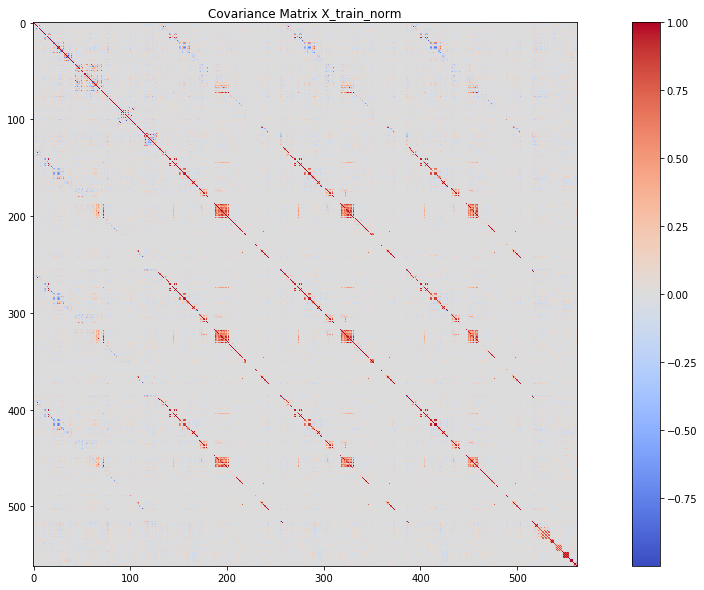

C:\Users\as166\Anaconda3\envs\monolith_env\lib\site-packages\numpy\lib\function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\as166\Anaconda3\envs\monolith_env\lib\site-packages\numpy\lib\function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


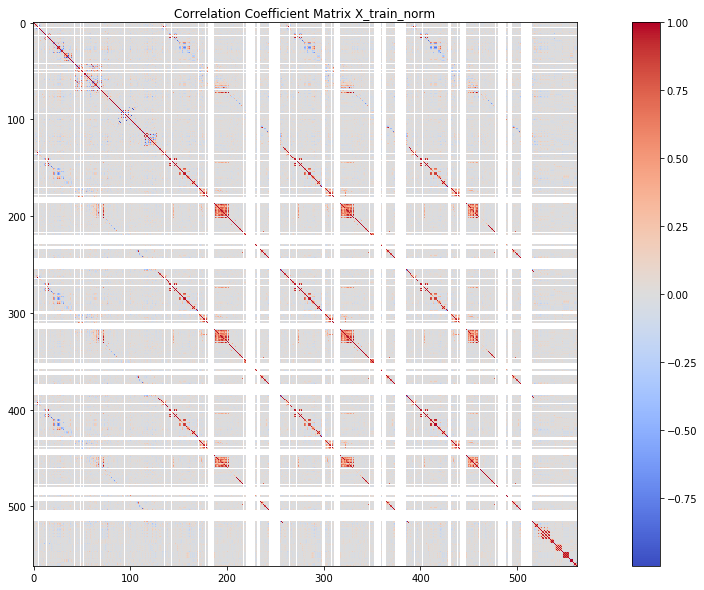

In [21]:
X_train_cov = np.cov(X_train_norm, rowvar=False)
plt.figure(figsize=(20,10))
plt.imshow(X_train_cov, cmap=plt.get_cmap('coolwarm'))
plt.colorbar()
plt.title('Covariance Matrix X_train_norm')
plt.show()
# Note there are features with high covariance which can be downselected.

X_train_cov = np.corrcoef(X_train_norm, rowvar=False)
plt.figure(figsize=(20,10))
plt.imshow(X_train_cov, cmap=plt.get_cmap('coolwarm'))
plt.title('Correlation Coefficient Matrix X_train_norm')
plt.colorbar()
plt.show()
# Note there are features with high covariance which can be downselected.


## Note:
- Covariance matrix of the sensor data seems to show that certain sensors are quite highly correlated.
- There could be some further feature downselection using this. 
- This is also likely why the Gaussian Elliptical Envelope Classification performed so well.

# 7. Attempt to resample the training set into 10 different data sets to train an ensemble of logistic regression classifiers

In [38]:
# Generate training and test sets
X_train, X_test, y_train, y_test = train_test_split(sensor_data, sensor_labels, random_state=5, stratify=sensor_labels)

# Print shapes for sanity check
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1175, 562)
(392, 562)
(1175,)
(392,)


In [39]:
# Normalise data set and separate training data based on classes

success_loc = np.where(y_train==1)
failure_loc = np.where(y_train==0)

# Carry out mean normalisation
mu, sigma, X_train_norm = mean_normalisation(X_train)
X_test_norm = (X_test[:,]-mu)/sigma

# Convert nans to zero (essentially making them mean values)
X_train_norm = NaNsToZero(X_train_norm)
X_test_norm = NaNsToZero(X_test_norm)

# Separate training data
X_train_success = X_train_norm[success_loc[0], :]
X_train_failure = X_train_norm[failure_loc[0], :]

print(X_train_success.shape)
print(X_train_failure.shape)

(78, 562)
(1097, 562)


C:\Users\as166\Anaconda3\envs\monolith_env\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
C:\Users\as166\Anaconda3\envs\monolith_env\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


In [46]:
# Upsample success data and downsample failure data to get equal sample sizes for testing the algorithm with a balanced data set.
# Upsample and downsample the data into 9 different data sets for training.
# Train 9 different logistic regression classifiers one for each newly sampled data set and use them to vote.


model_holder=[]
for i in range(9):
    
    # Resample the training set for training run to provide a more balanced set.
    X_train_failure_downsampled= resample(X_train_failure, replace=False, n_samples=500)
    X_train_success_upsampled = resample(X_train_success, replace=True, n_samples=500)
    
    # Generate sampled training set
    X_train_sampled = np.vstack((X_train_failure_downsampled, X_train_success_upsampled))
    y_train_sampled = np.vstack((np.zeros(shape=(X_train_failure_downsampled.shape[0],1)), np.ones(shape=(X_train_success_upsampled.shape[0],1))))
    print(X_train_sampled.shape, y_train_sampled.shape)
    
    # Shuffle the training set and labels the same way.
    s=np.arange(y_train_sampled.shape[0])
    np.random.shuffle(s)
    X_train_sampled = X_train_sampled[s,:]
    y_train_sampled = y_train_sampled[s]
    
    # Train the logistic regression classifier and store it in a list.
    model_holder.append(LogisticRegression(random_state=5, solver='saga', max_iter=5000, penalty='l1').fit(X_train_sampled[:, feature_select], y_train_sampled.flatten()))

(1000, 562) (1000, 1)
(1000, 562) (1000, 1)
(1000, 562) (1000, 1)
(1000, 562) (1000, 1)
(1000, 562) (1000, 1)
(1000, 562) (1000, 1)
(1000, 562) (1000, 1)
(1000, 562) (1000, 1)
(1000, 562) (1000, 1)


In [47]:
# Initialise y_pred array.
y_pred = np.zeros(shape=(y_test.shape[0],len(model_holder)))
y_prob = np.zeros(shape=(y_test.shape[0],len(model_holder)))
# Loop through each classifier and predict on the test set
for i, model in enumerate(model_holder):
    y_pred[:,i] = model.predict(X_test_norm[:,feature_select])
    temp_proba = model.predict_proba(X_test_norm[:,feature_select])
    y_prob[:,i] = temp_proba[:,1]
    
    # Generate performance metrics of each model
    precision = sk.metrics.precision_score(y_test, y_pred[:,i], pos_label=1)
    recall = sk.metrics.recall_score(y_test, y_pred[:,i], pos_label=1)
    roc_auc = sk.metrics.roc_auc_score(y_test, y_pred[:,i])
    f1 = f1_score(y_test, y_pred[:,i], pos_label=1)
    print('F1 score = ' + str(f1)+ '\n precision = ' + str(precision) + '\n recall = ' + str(recall) + '\n roc_auc = '+ str(roc_auc) + '\n')

print(y_pred)

# Conduct voting of each model
y_pred_bagged,_ = stats.mode(y_pred, axis=1)
y_prob_bagged = y_prob.mean(axis=1)

# Generate performance metrics of voted results.
precision = sk.metrics.precision_score(y_test, y_pred_bagged, pos_label=1)
recall = sk.metrics.recall_score(y_test, y_pred_bagged, pos_label=1)
roc_auc = sk.metrics.roc_auc_score(y_test, y_prob_bagged)
f1 = f1_score(y_test, y_pred_bagged, pos_label=1)
print('\nBagged Logistic Regression Model Results:\n\n' + 'F1 score = ' + str(f1)+ '\n precision = ' + str(precision) + '\n recall = ' + str(recall) + '\n roc_auc = '+ str(roc_auc) + '\n')

thresholds = np.arange(0, 1, 0.1)
precision_list=[]
recall_list=[]
f1_list =[]
for threshold in thresholds:
    y_pred_bagged[y_prob_bagged > threshold] = 1
    y_pred_bagged[y_prob_bagged <= threshold] = 0
    precision_list.append(sk.metrics.precision_score(y_test, y_pred_bagged, pos_label=1))
    recall_list.append(sk.metrics.recall_score(y_test, y_pred_bagged, pos_label=1))
    f1_list.append(f1_score(y_test, y_pred_bagged, pos_label=1))
    
print(precision_list)
print(recall_list)
print(f1_list)
print(thresholds)

F1 score = 0.2518518518518518
 precision = 0.1559633027522936
 recall = 0.6538461538461539
 roc_auc = 0.7012400168137872

F1 score = 0.23188405797101452
 precision = 0.14285714285714285
 recall = 0.6153846153846154
 roc_auc = 0.6765447667087011

F1 score = 0.26666666666666666
 precision = 0.1651376146788991
 recall = 0.6923076923076923
 roc_auc = 0.7218369062631359

F1 score = 0.23448275862068965
 precision = 0.14285714285714285
 recall = 0.6538461538461539
 roc_auc = 0.6875788146279949

F1 score = 0.25757575757575757
 precision = 0.16037735849056603
 recall = 0.6538461538461539
 roc_auc = 0.7053383774695251

F1 score = 0.2714285714285714
 precision = 0.16666666666666666
 recall = 0.7307692307692307
 roc_auc = 0.7356031946195882

F1 score = 0.2706766917293233
 precision = 0.16822429906542055
 recall = 0.6923076923076923
 roc_auc = 0.7245691467002943

F1 score = 0.273972602739726
 precision = 0.16666666666666666
 recall = 0.7692307692307693
 roc_auc = 0.748003362757461

F1 score = 0.279

## 7.2 Summary of Bagged Logistic Regression Classifier

- Training data was equally resampled with equal numbers in each class, 9 different times.
- 9 different logistic regression classifiers were trained. 
- The probabilities of predicting a success from each classifier were averaged and used to make predictions on the test data.
- It was found that only marginal improvements were made through the use of bagging.

# 8. Decision Trees

## Notes:

- Attempted decision tree algorithms as they were supposedly good at dealing with imbalanced classes. This was not the case here both algorithms were unable to predict any successes.

In [26]:
# Generate training and test sets
X_train, X_test, y_train, y_test = train_test_split(sensor_data, sensor_labels, random_state=5, stratify=sensor_labels)

# Carry out mean normalisation
mu, sigma, X_train_norm = mean_normalisation(X_train)
X_test_norm = (X_test[:,]-mu)/sigma

# Convert nans to zero (essentially making them mean values)
X_train_norm = NaNsToZero(X_train_norm)
X_test_norm = NaNsToZero(X_test_norm)

C:\Users\as166\Anaconda3\envs\monolith_env\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
C:\Users\as166\Anaconda3\envs\monolith_env\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


In [27]:

RForest = sk.ensemble.RandomForestClassifier(n_estimators=100, class_weight='balanced')
RForest.fit(X_train_norm[:, feature_select], y_train)
y_pred = RForest.predict(X_test_norm[:, feature_select])

print(y_pred)
precision = sk.metrics.precision_score(y_test, y_pred, pos_label=1)
recall = sk.metrics.recall_score(y_test, y_pred, pos_label=1)
roc_auc = sk.metrics.roc_auc_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, pos_label=1)
print('F1 score = ' + str(f1)+ '\n precision = ' + str(precision) + '\n recall = ' + str(recall) + '\n roc_auc = '+ str(roc_auc))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
F1 score = 0.0
 precision = 0.0
 recall = 0.0
 roc_auc = 0.5


C:\Users\as166\Anaconda3\envs\monolith_env\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\as166\Anaconda3\envs\monolith_env\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [28]:
ExtraTrees = sk.ensemble.ExtraTreesClassifier(n_estimators=100, class_weight='balanced_subsample')
ExtraTrees.fit(X_train_norm, y_train)
y_pred = ExtraTrees.predict(X_test_norm)

print(y_pred)
precision = sk.metrics.precision_score(y_test, y_pred, pos_label=1)
recall = sk.metrics.recall_score(y_test, y_pred, pos_label=1)
roc_auc = sk.metrics.roc_auc_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, pos_label=1)
print('F1 score = ' + str(f1)+ '\n precision = ' + str(precision) + '\n recall = ' + str(recall) + '\n roc_auc = '+ str(roc_auc))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
F1 score = 0.0
 precision = 0.0
 recall = 0.0
 roc_auc = 0.5


C:\Users\as166\Anaconda3\envs\monolith_env\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\as166\Anaconda3\envs\monolith_env\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
